In [62]:

import torchvision
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp, softmax
from sklearn.decomposition import PCA 
import math
from tqdm import tqdm

MAX_ITER = 100
EPSILON = 1e-10
TOLERANCE = 1e-5

class GMM:
    def __init__(self, K, d):
        self.K_RANGE = K
        self.pi = softmax(np.random.normal(scale = 0.1, size=(K,)))
        self.mu = np.random.normal(scale = 0.1, size =(K, d))
        self.S = np.random.lognormal(sigma=0.1, size=(K, d)) # All positive

    def EM_STEP(self, X):
        N, d = X.shape
        log_r = np.zeros((N, self.K_RANGE))
        loss = []

        for iter in range(MAX_ITER):
            for k in range(self.K_RANGE):
                log_r[:,k] = np.log(self.pi[k] + EPSILON) - 0.5 * np.sum(np.log(self.S[k] + EPSILON)) - 0.5 * np.dot((X-self.mu[k]) ** 2, 1/(self.S[k] + EPSILON))
            
            log_r_i = logsumexp(log_r, axis = 1)
            log_r = log_r - log_r_i[:,None]
            loss.append(-np.sum(log_r_i))

            if iter > 1 and abs(loss[iter] - loss[iter-1]) <= TOLERANCE * abs(loss[iter]):
                break

            r = np.exp(log_r)
            r_dot_k = np.sum(r, axis = 0)
            self.pi = r_dot_k / N
            self.mu = np.matmul(r.T, X) / (r_dot_k[:,None] + EPSILON)
            self.S = np.matmul(r.T, X**2) / (r_dot_k[:,None] + EPSILON) - self.mu ** 2

        return loss
    
    def sort_models(self):
        indices = np.argsort(self.pi)
        self.pi, self.mu, self.S = self.pi[indices], self.mu[indices], self.S[indices]

    def p_theta(self, X):
        p = 0
        for k in range(self.K_RANGE):
            exp_power = -0.5 * np.dot((X-self.mu[k]) ** 2, 1/(self.S[k] + EPSILON))
            p += self.pi[k] * np.power(np.product(self.S[k]) * 2 * math.pi + EPSILON, -0.5) * np.exp(exp_power)
        return p
    
    def __str__(self):
        ret = "GMM Model with K = {}\n".format(self.K_RANGE)

        for k in range(self.K_RANGE):
            ret += "========Parameters for model {}=========\n".format(k)
            ret += "---Weights = {}\n".format(self.pi[k])
            ret += "---Means = {}\n".format(self.mu[k])
            ret += "---Variance = {}\n".format(self.S[k])
        return ret
transform = transforms.Compose([transforms.ToTensor()])


training GMM with k = 0
training GMM with k = 1
training GMM with k = 2
training GMM with k = 3
training GMM with k = 4
training GMM with k = 5
training GMM with k = 6
training GMM with k = 7
training GMM with k = 8
training GMM with k = 9


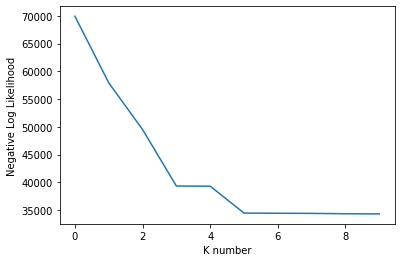

In [72]:
X = np.loadtxt(open("gmm_dataset.csv", "rb"), delimiter=",")
n, d = X.shape
MAX_K = 10
models, losses = [None] * MAX_K, [None] * MAX_K
for k in range(10):
    print(f"training GMM with k = {k}")
    model = GMM(k+1, d)
    loss = model.EM_STEP(X)
    models[k] = model
    losses[k] = loss[-1]

plt.plot(losses)
plt.xlabel("K number")
plt.ylabel("Negative Log Likelihood")
plt.savefig("gmm_loss.png", transparent=False)
plt.show()

In [78]:
choose_of_k = 5

print(f"Choose k to be {choose_of_k}")

chosen_model = models[choose_of_k-1]
chosen_model.sort_models()
print(chosen_model)



Choose k to be 5
GMM Model with K = 5
========Parameters for model 0=========
---Weights = 0.012149022366402182
---Means = [-0.71118778 -0.51652233 -0.694506   -1.73751139  0.10280086 -0.65190711
 -2.0643607   0.24881163 -0.8323711   0.22952811  1.17827208 -0.14248053
  1.22096289 -0.89979927  1.05089612 -0.4901747   0.05149158 -0.87880974
  0.08197796  0.03603793]
---Variance = [0.64627987 2.35182502 1.00524562 0.13439717 2.46732699 0.85261726
 1.12499833 2.27824505 1.0313166  0.44311031 0.86006935 0.5709815
 0.91348845 0.43266023 1.12378261 0.80544136 0.94170524 0.53833318
 0.53379455 0.0370334 ]
========Parameters for model 1=========
---Weights = 0.19966381575964276
---Means = [-0.44267848  0.50391154  0.950766    0.81728867  2.09622268 -1.20176037
  0.47390156 -0.18721435  0.71796721  0.90632485  0.08468847  0.90059829
 -0.05950644 -0.93576893  0.05206341  0.25547972  1.34236937  0.50456567
 -0.07727331 -0.58232248]
---Variance = [5.55600904 1.14899773 0.84355382 3.45094378 0.9760

# QUESTION2 MNIST

In [74]:
root = './data'
train_data = datasets.MNIST(root = root, train= True, transform=None, download=True)
test_data = datasets.MNIST(root = root, train= False, transform=None, download=True)

train_N, d1, d2 = train_data.data.shape
train_X = np.reshape(train_data.data, (train_N, d1 * d2))
train_Y = train_data.targets.numpy()

test_N, d1, d2 = test_data.data.shape
test_X = np.reshape(test_data.data, (test_N, d1 * d2))
test_Y = test_data.targets.numpy()

d = 40

reducer = PCA(n_components=d)
reducer.fit(train_X)

train_data_reduced = reducer.transform(train_X)
test_data_reduced = reducer.transform(test_X)
train_X = reducer.transform(train_X)
test_X = reducer.transform(test_X)

In [75]:
K_RANGE = 10

def train(X, y):
    x_splits = [None] * 10 # 10 splits of train_X
    for identify_class in range(10):
        indices = y == identify_class
        x_splits[identify_class] = X[indices]
    
    total = len(X)
    P_y_c = [len(x_c) / total for x_c in x_splits]
    
    models_k = [None] * K_RANGE
    for k in range(K_RANGE):
        print(f"========training GMMs with k = {k}========")
        models = [None] * 10
        for identify_class in tqdm(range(10)):
            model = GMM(k+1, d)
            model.EM_STEP(x_splits[identify_class])
            models[identify_class] = model

        models_k[k] = models
    return models_k, P_y_c

def test(X, y, models_k, P_y_c):
    y_total = len(y)
    errors = [None] * K_RANGE
    for k in range(K_RANGE):
        print(f"========testing GMMs with k = {k}========")
        models = models_k[k]
        error_count = 0
        for i in tqdm(range(y_total)):
            test_x, test_y = X[i], y[i]
            probs = [model.p_theta(test_x) * P_y_c[c] for c, model in enumerate(models)]
            y_hat = np.argmax(probs)
            if y_hat != test_y:
                error_count += 1
        errors[k] = error_count / y_total
        print(f"When K = {k}, Error rate: {errors[k]}")
    return errors

In [76]:
models_k, pyc = train(train_data_reduced, train_Y)

========training GMMs with k = 0========


100%|██████████| 10/10 [00:00<00:00, 277.71it/s]


========training GMMs with k = 1========


100%|██████████| 10/10 [00:00<00:00, 19.38it/s]


========training GMMs with k = 2========


100%|██████████| 10/10 [00:00<00:00, 13.06it/s]


========training GMMs with k = 3========


100%|██████████| 10/10 [00:00<00:00, 10.58it/s]


========training GMMs with k = 4========


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


========training GMMs with k = 5========


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


========training GMMs with k = 6========


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


========training GMMs with k = 7========


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


========training GMMs with k = 8========


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


========training GMMs with k = 9========


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


In [77]:
errors = test(test_data_reduced, test_Y, models_k, pyc)

========testing GMMs with k = 0========


100%|██████████| 10000/10000 [00:01<00:00, 8494.26it/s]


When K = 0, Error rate: 0.1255
========testing GMMs with k = 1========


100%|██████████| 10000/10000 [00:02<00:00, 4477.27it/s]


When K = 1, Error rate: 0.1126
========testing GMMs with k = 2========


100%|██████████| 10000/10000 [00:03<00:00, 3038.83it/s]


When K = 2, Error rate: 0.0987
========testing GMMs with k = 3========


100%|██████████| 10000/10000 [00:04<00:00, 2290.96it/s]


When K = 3, Error rate: 0.0895
========testing GMMs with k = 4========


100%|██████████| 10000/10000 [00:05<00:00, 1855.56it/s]


When K = 4, Error rate: 0.0847
========testing GMMs with k = 5========


100%|██████████| 10000/10000 [00:06<00:00, 1549.52it/s]


When K = 5, Error rate: 0.0763
========testing GMMs with k = 6========


100%|██████████| 10000/10000 [00:07<00:00, 1334.10it/s]


When K = 6, Error rate: 0.0717
========testing GMMs with k = 7========


100%|██████████| 10000/10000 [00:08<00:00, 1169.46it/s]


When K = 7, Error rate: 0.0779
========testing GMMs with k = 8========


100%|██████████| 10000/10000 [00:09<00:00, 1034.21it/s]


When K = 8, Error rate: 0.072
========testing GMMs with k = 9========


100%|██████████| 10000/10000 [00:10<00:00, 923.53it/s]

When K = 9, Error rate: 0.0698


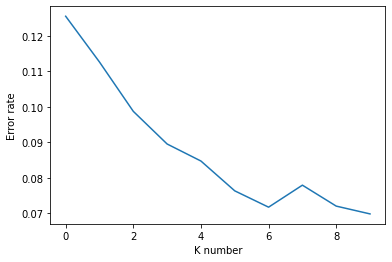

In [82]:
plt.plot(errors)
plt.xlabel("K number")
plt.ylabel("Error rate")
plt.savefig("gmm_loss.png", transparent=False)
plt.show()